## Regressão simbólica aplicada ao modelo populacional de Verhulst

In [1]:
# Imports de bibliotecas e funções

from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import verhulst, runge_kutta

### Solução numérica para o modelo dada pelo método de Runge-Kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(verhulst, T0, X0, TF, H, K)

### Algoritmo genético de Regressão simbólica 

In [3]:
# Constantes relacionadas a busca

NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
def Div(left, right):
    if type(right) == float:
        if right == 0:
            #print('div error')
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros
        return result

def Exp(x):
    try:
        result = np.exp(x)
    except OverflowError:
        print('exp error')
        result = np.ones_like(x)
    return result

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(X0_add, 1)
#pset.addPrimitive(X0_mul, 1)
#pset.addPrimitive(X0_div, 1)
#pset.addPrimitive(K_add, 1)
#pset.addPrimitive(K_mul, 1)
#pset.addPrimitive(K_div, 1)

pset.addEphemeralConstant("rand103", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                      fitness                      	                 size                 
   	      	---------------------------------------------------	--------------------------------------
gen	nevals	avg        	gen	min    	nevals	std        	avg  	gen	min	nevals	std   
0  	1000  	5.37623e+40	0  	1.10135	1000  	1.20096e+42	3.843	0  	2  	1000  	1.6554
1  	527   	14.9291    	1  	1.10135	527   	17.497     	3.509	1  	1  	527   	1.57414
2  	493   	1.00319e+41	2  	1.10135	493   	2.47097e+42	3.469	2  	1  	493   	1.64409
3  	538   	5.37623e+40	3  	1.10135	538   	1.20096e+42	3.752	3  	1  	538   	1.74485
4  	510   	11.6742    	4  	1.10135	510   	17.6563    	4.059	4  	1  	510   	1.77525
5  	494   	12.1062    	5  	1.10135	494   	28.9958    	4.469	5  	1  	494   	1.68909
6  	518   	6.12103e+12	6  	1.10135	518   	1.93467e+14	4.766	6  	1  	518   	1.71267
7  	489   	2.68812e+40	7  	1.10135	489   	8.49632e+41	5.091	7  	1  	489   	1.7472 


C:\Users\ANA220~1\AppData\Local\Temp/ipykernel_36244/2881555872.py:18: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\ANA220~1\AppData\Local\Temp/ipykernel_36244/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))
c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


8  	525   	inf        	8  	1.10135	525   	nan        	5.493	8  	1  	525   	1.71463
9  	571   	1.16095e+14	9  	1.10135	571   	2.92044e+15	5.869	9  	1  	571   	1.69111
10 	488   	inf        	10 	1.10135	488   	nan        	6.137	10 	1  	488   	1.56532
11 	513   	inf        	11 	1.10135	513   	nan        	6.391	11 	1  	513   	1.45949
12 	504   	inf        	12 	1.10135	504   	nan        	6.475	12 	1  	504   	1.35476
13 	526   	inf        	13 	1.10135	526   	nan        	6.531	13 	2  	526   	1.3539 
14 	514   	18.7614    	14 	1.10135	514   	59.3574    	6.555	14 	3  	514   	1.3744 
15 	483   	4.81301e+14	15 	1.10135	483   	1.50201e+16	6.551	15 	1  	483   	1.32944
16 	551   	inf        	16 	1.10135	551   	nan        	6.525	16 	1  	551   	1.36065
17 	516   	18.3775    	17 	1.10135	516   	57.5371    	6.479	17 	2  	516   	1.31817
18 	519   	inf        	18 	1.10135	519   	nan        	6.55 	18 	1  	519   	1.44274
19 	548   	inf        	19 	1.10135	548   	nan        	6.572	19 	1  	548   	1.49359
20 	

In [11]:
for i in hof.items:
    print(str(i))
    print()

Div(Exp(1), sub(add(t, t), sub(t, Div(t, t))))

Div(Exp(1), sub(add(t, t), sub(t, add(0, 1))))

Div(Exp(1), sub(add(t, mul(1, t)), sub(t, 1)))

Div(Exp(1), sub(add(t, t), sub(t, Exp(0))))

Div(Exp(1), sub(add(t, t), sub(t, 1)))



### Reportando melhor individuo encontrado 

Div(Exp(1), sub(add(t, t), sub(t, Div(t, t))))


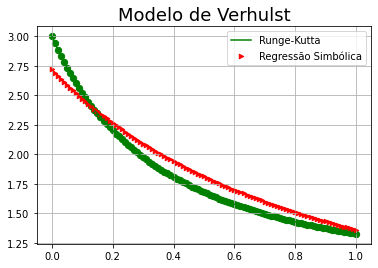

In [12]:
melhor_individuo = str(hof.items[0])
print(melhor_individuo)

func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)


fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Verhulst', size = 18)
ax.scatter(T, X, c = 'g', s = 40)
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r', s = 20)
ax.plot(T, Xexpr, c = 'r')

ax.legend()

ax.grid('--')
#plt.savefig('resultados\Resultado_Verhulst_1.png', dpi = 200)

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand104", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
print("O melhor individuo encontrado: ")
display(sp.expand(func(t)))

O melhor individuo encontrado: 


E/(t + 1)